In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
FORCE = False

# AppVoCAI Dataset Cleaning
---
In the previous section, we analyzed the AppVoCAI dataset, evaluating its validity, completeness, uniqueness, relevance, and adherence to data privacy concerns. This section is about duplicate deleting, language filtering, artifact removing, PII masking, character normalizing, data cleaning. 

Our data cleaning methodology focuses on addressing critical data quality issues that could undermine the integrity of downstream analyses, while preserving the text as close to its original form as possible. By adopting this conservative approach, we tackle key issues without sacrificing the nuance and representativeness of the data, ensuring the models are presented with rich, authentic input.

## Data Cleaning Key Evaluation Questions (KEQs)
---
Although, this data cleaning approach comprises many of the preprocessing techniques commonly found in the literature {cite}`symeonidisComparativeEvaluationPreprocessing2018`, the following data cleaning approach is motivated by three guiding questions.

1. What’s essential to remove, and what can be left intact to preserve meaning?
2. How do we best preserve text richness and nuance?
3. How can the data cleaning process best exploit model strengths towards optimal model performance?

These Key Evaluation Questions (KEQs) crystallized our approach which balances data quality with model sophistication.


### Import Libraries
---

In [2]:
from genailab.flow.dataprep.clean.task import DatasetFinalCleaner
from genailab.setup import auto_wire_container
from genailab.analytics.dqa import DQA
from genailab.core.dtypes import DFType
from genailab.infra.utils.file.fileset import FileFormat
from genailab.flow.dataprep.clean.builder import DataCleaningStageBuilder
from genailab.flow.dataprep.dqa.builder import DataQualityAssessmentStageBuilder
from genailab.asset.dataset.config import DatasetConfig
from genailab.core.flow import PhaseDef, StageDef

# Wire container
container = auto_wire_container()
repo = container.io.repo()

## Data Cleaning Approach
---
The following describes our data cleaning process and steps, executed in the order listed. We begin with 'safe' techniques that carry minimal risk of compromising downstream cleaning tasks. For instance, UTF-8 encoding can impact the accuracy of language detection algorithms, especially if characters carry language-specific information. Removing special characters may compromise the detection of Personally Identifiable Information (PII) such as URLs and email addresses. As the process progresses, steps carry a greater impact on the data, its expressiveness, and representation.

Our minimalist, task-specific, model-informed, *leave-as-is* data cleaning process unfolds as follows:

1. **Relevance**: Observations containing **non-English text or app names** will be removed to maintain linguistic uniformity within the dataset, which is crucial for consistent language-based analysis. 
2. **Uniqueness**: For duplicate review IDs, our policy for retention is based on review date. Retaining the most recent review prioritizes review recency, timeliness and relevance. Observations containing duplicate review text will be retained to maximize fidelity to customer experience and expression. 
3. **Privacy**: Personally identifiable information (PII) such as URLs, email addresses and phone numbers detected in the previous section are removed from the dataset to ensure adherence to data privacy and minimal information policies.
4. **Validity**: Replace or remove artifacts, patterns, and noise that do not convey meaningful content, and may compromise dataset validity. Remediations include:
    1. **Control Characters**: Remove HTML entities (e.g., `&amp;`, `&#39;`), and non-printable characters from the Unicode and ASCII character sets used to control text flow or hardware devices (e.g., newline, tab, or carriage return). These characters have no analytical value and can interfere with text processing.
    2. **Diacritics and Accents**:  We normalize accented characters (e.g., converting `é` to `e`) to reduce unnecessary text variation, which simplifies analysis without compromising the meaning of the content.
    3. **Elongation**: Elongated words (e.g., "soooo") convey emphasis in informal text, which is valuable for sentiment analysis. We use a threshold approach to limit characters that appear four or more times consecutively to a maximum of three (e.g., "soooo" becomes "sooo"), preserving emphasis while maintaining readability.
    4. **Repetition**: Excess character, sequence, word and phrase repetition is reduced, but not eliminated to perserve artifacts that may signal emphasis.
    5. **Special Characters**: Excessive special characters can indicate SPAM, emotional intensity, or nonsensical content. We apply a threshold: if special characters make up more than 35% of the review text, the review is removed.     
    6. **Trim Whitespace**: We trim excess whitespace from review text.
5. **Non-Informative Reviews**: Reviews that don't match minimum length criteria are removed.


### Data Cleaning Techniques Not Implemented
---
In natural language processing (NLP), text cleaning measures such as lower-casing, contraction and abbreviation expansion, spelling correction, and the removal of emoticons, emojis, and other artifacts are considered standard practice. Given that transformer models are fine-tuned on large user generated content datasets such as the IMDB Movie and SemEval Laptop Reviews dataset, they are highly adept at handling a wide variety of tokens, including emojis, spelling variations, abbreviations and contractions. So, we take a **leave emojis as-is** approach. By leveraging the inherent strengths of transformer - particularly their ability to tokenize subword units and learn from context — we preserve the natural, authentic nature of user-generated content.

## Data Cleaning Pipeline
---
Following our established pipeline construction process, we specify the source and target dataset configurations and obtain an Apache Spark Session to facilitate data processing. 

> Hey Siri, queue the **Data Cleaning** playlist.

In [3]:
# Source Dataset Configuration
source_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.DQA,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)

# Target Dataset Configuration
target_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.SEMICLEAN,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)


In [4]:
# Create builder
cleaning_stage = (
    DataCleaningStageBuilder()
    .partition_dataset()
    .clean_non_english()
    .clean_privacy_issues()
    .clean_duplication()
    .clean_invalid_values()
    .clean_elongation(threshold=3, max_elongation=2)
    .clean_special_chars()
    .clean_invalid_characters()
    .clean_excess_special_chars(threshold=0.35)
    .clean_repeated_words(threshold=3, max_repetitions=1)
    .clean_repeated_sequences(length_of_sequence=3, threshold=3, max_repetitions=3)
    .clean_repeated_phrases(length_of_phrase=2, threshold=2, max_repetitions=2)
    .clean_short_reviews(threshold=5)
    .clean_excess_whitespace()
    .build(source_config=source_config, target_config=target_config)
)
# Run the stage
semiclean_dataset = cleaning_stage.run(force=FORCE)

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).




# ============================================================================== #
#                Semi-Clean Data Stage Sat, 08 Feb 2025 14:48:28                 #
# ============================================================================== #



Obtained the Semi-Clean Data Stage target dataset dataprep_semiclean_dataset_review from cache.
To force execution, run the stage with force=True.
____________________________________________________________________________________________________
Semi-Clean Data Stage                   14:48:28    14:48:33    5.27 seconds                        


# ============================================================================ #



## Data Quality Verification Pipeline
---
This data quality verification pipeline assesses the degree to which the cleaned dataset meets quality criteria for validity, relevance, completeness, privacy, and uniqueness. Due to the size of the production dataset and the computational cost of performing a full data quality assessment (DQA), this pipeline employs a sampling strategy to efficiently estimate data quality metrics.

**Sampling Methodology:**

The pipeline uses *random sampling without replacement*. This method ensures that each row in the cleaned dataset has an equal probability of being selected for the sample. Sampling without replacement means that once a row is selected, it cannot be selected again, preventing duplicate rows in the sample. Random sampling is used to obtain a representative subset of the data, allowing us to estimate data quality metrics for the entire dataset without processing every single row. This significantly reduces the time and resources required for DQA.

**Sample Size Calculation:**

The sample size is determined based on the following parameters:

* **Z-score (z):** 1.96. This corresponds to a 95% confidence level. It indicates that if we were to repeat this sampling process many times, 95% of the samples would accurately reflect the population within the specified margin of error.

* **Estimated Proportion (p):** 0.5. This is a conservative estimate for the proportion of data quality issues. Using 0.5 maximizes the calculated sample size, ensuring that the sample is large enough even if the true proportion of issues is unknown. If prior knowledge suggests a different proportion, this value can be adjusted.

* **Margin of Error (moe):** 0.01 (or 1%). This defines the acceptable range of deviation between the data quality metrics calculated from the sample and the true metrics for the entire dataset. We aim to be 95% confident that the true value is within 1% of the value observed in the sample.

The sample size (n) is calculated using the following formula:

```
n = (Z^2 * p * (1-p)) / moe^2
```

This formula balances the desired confidence level, the estimated variability in the data, and the acceptable margin of error to determine the minimum sample size required for statistically significant results.

**Benefits of Sampling:**

* **Reduced Processing Time:** By performing DQA on a sample, we drastically reduce the amount of data that needs to be processed, leading to significant time savings.
* **Resource Efficiency:** Sampling reduces the computational resources (memory, CPU) required for DQA.
* **Cost-Effectiveness:** Processing smaller samples translates to lower infrastructure costs.

**Limitations:**

* **Estimation:** The DQA results obtained from the sample are *estimates* of the true data quality metrics for the entire dataset. While we aim for a high level of confidence (95%), there is still a small chance that the sample might not perfectly represent the population.
* **Margin of Error:** The chosen margin of error defines the level of uncertainty in our estimates. A smaller margin of error requires a larger sample size and more processing time.

**Next Steps:**

Following the sampling process, the pipeline will perform the defined data quality checks on the sampled data. The results will then be extrapolated to provide an estimated overview of the data quality across the entire dataset. If the DQA on the sample reveals significant data quality issues, further investigation and potentially a full DQA on the entire dataset might be necessary.


In [5]:
# Source Dataset Configuration
source_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.SEMICLEAN,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)

# Target Dataset Configuration
target_config = DatasetConfig(
    phase=PhaseDef.DATAPREP,
    stage=StageDef.DQV,
    name="review",
    file_format=FileFormat.PARQUET,
    asset_type="dataset",
    dftype=DFType.SPARK,
)

In [6]:
# Create builder
builder = DataQualityAssessmentStageBuilder()
dqv_stage = (
    builder
    .sample_dataset(z=1.96, p=0.5, moe=0.01) # For 95% Confidence and a 0.01 (1%%) margin of error
    .partition_dataset()
    .detect_non_english(fast=True)
    .detect_privacy_issues()
    .detect_duplication()
    .detect_invalid_values()
    .detect_elongation(threshold=3, max_elongation=2)
    .detect_special_chars()
    .detect_invalid_characters()
    .detect_excess_special_chars(threshold=0.35)
    .detect_repeated_words(threshold=3, max_repetitions=1)
    .detect_repeated_sequences(threshold=3, max_repetitions=3)
    .detect_repeated_phrases(length_of_phrase=2, threshold=2, max_repetitions=2)
    .detect_excess_whitespace()
    .detect_short_reviews(threshold=5)
    .build(source_config=source_config, target_config=target_config)
)

# Run the stage
dqv_dataset = dqv_stage.run(force=FORCE)



# ============================================================================== #
#            Data Quality Assessment Stage Sat, 08 Feb 2025 14:48:35             #
# ============================================================================== #

Obtained the Data Quality Assessment Stage target dataset dataprep_dqv_dataset_review from cache.
To force execution, run the stage with force=True.
____________________________________________________________________________________________________
Data Quality Assessment Stage           14:48:35    14:48:36    0.31 seconds                        


# ============================================================================ #



## Data Quality Verification
---

The Data Quality Analysis is performed in Pandas, so let's get a Pandas version of the dataset.

In [7]:
# Target Dataset
dqv_dataset = repo.get(asset_id=dqv_dataset.asset_id, dftype=DFType.PANDAS)

,Dimension,Score
0,Completeness,1.000000
1,Validity,0.998999
2,Relevance,1.000000
3,Uniqueness,1.000000
4,Privacy,0.999583


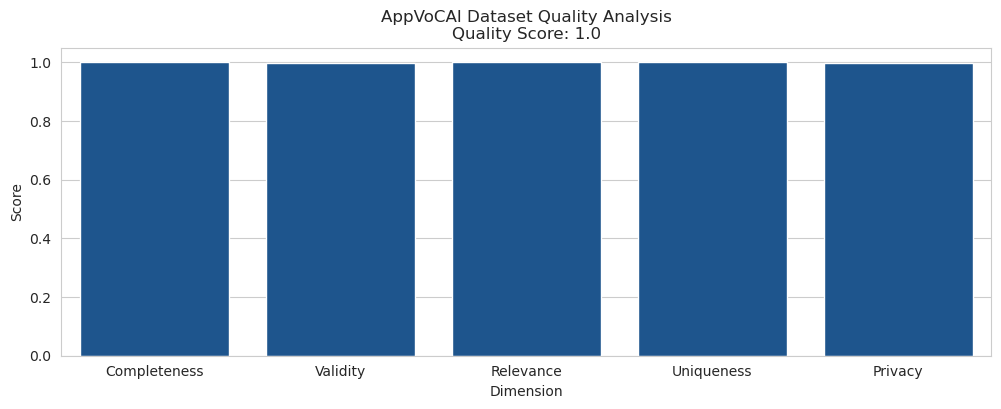

In [8]:
# Execute the Data Quality Verification
dqa = DQA(dataset=dqv_dataset)
dqa.analyze_quality()

### Data Quality Verification Impressions
---
The data quality verification reveals strong performance across key dimensions. Completeness reflects some variation in app category coverage, which will be addressed during pre-training and instance selection. Validity confirms adherence to expected formats and rules, ensuring a high signal-to-noise ratio in the text. Relevance is achieved by filtering out non-English reviews and those too short to provide meaningful information for aspect-based sentiment analysis. The dataset is free from duplication, and high privacy compliance is maintained through the removal of personally identifiable information.

Finally, we finalize the cleaned dataset and persist it to the repository.

In [9]:
cleaner = DatasetFinalCleaner()
clean_dataset = cleaner.run(asset_id=semiclean_dataset.asset_id)

### Summary and Profile
Lastly, lets verify the cleaned dataset with a summary, a profile of its structure and a few rows sampled from the dataset.


In [10]:
clean_dataset.summary



                            AppVoCAI Dataset Summary                            
                             Data Preparation Phase                             
                                Clean Data Stage                                
                       Number of Reviews | 18,006,500
                     Number of Reviewers | 12,894,460
              Number of Repeat Reviewers | 2,863,303 (22.2%)
         Number of Influential Reviewers | 954,833 (7.4%)
                          Number of Apps | 35,424
                 Average Reviews per App | 508.3
                    Number of Categories | 14
                                Features | 11
                       Min Review Length | 9
                       Max Review Length | 6,003
                   Average Review Length | 178.88
                        Memory Size (Mb) | 7,656,188,682.0
                    Date of First Review | 2008-07-10 10:15:37
                     Date of Last Review | 2023-09-03 02:14:35


In [11]:
clean_dataset.profile

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,StringType(),18006500,0,1.0,18006500,0,1.000000e+00,7656188682
1,app_id,StringType(),18006500,0,1.0,35424,17971076,1.967290e-03,7656188682
2,app_name,StringType(),18006500,0,1.0,35411,17971089,1.966568e-03,7656188682
3,category_id,StringType(),18006500,0,1.0,14,18006486,7.774970e-07,7656188682
4,author,StringType(),18006500,0,1.0,12894460,5112040,7.161003e-01,7656188682
5,rating,ShortType(),18006500,0,1.0,5,18006495,2.776775e-07,7656188682
6,content,StringType(),18006500,0,1.0,17684773,321727,9.821327e-01,7656188682
7,vote_sum,LongType(),18006500,0,1.0,503,18005997,2.793436e-05,7656188682
8,vote_count,LongType(),18006500,0,1.0,677,18005823,3.759753e-05,7656188682
9,date,TimestampNTZType(),18006500,0,1.0,17011203,995297,9.447257e-01,7656188682


In [12]:
clean_dataset.dataframe.show(n=5, truncate=False, vertical=False)

+----------+---------+-----------------------------+-----------+--------------------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+----------+-------------------+----------------+
|id        |app_id   |app_name                     |category_id|author              |rating|content                                                                                                                                                                           |vote_sum|vote_count|date               |category        |
+----------+---------+-----------------------------+-----------+--------------------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+----------+-------------------+----------------+
|1089228505|3

Great! Next, we do some housecleaning, then we move on to text quality analysis, a crucial step for ABSA model fine-tuning instance selection.

In [13]:
# Stop Spark Session
container.spark.session_pool().stop()